In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
#pip install category_encoders
import category_encoders as ce

from sklearn.model_selection import train_test_split , GridSearchCV , cross_val_score , RandomizedSearchCV,KFold,RepeatedKFold

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder , LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import get_scorer
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_percentage_error
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import shap
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection  import RFE
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer


from matplotlib.colors import ListedColormap
from sklearn.model_selection import cross_val_score
from sklearn import svm 
from sklearn.svm import LinearSVC
from itertools import product
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.inspection import permutation_importance
from IPython.display import display
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, RocCurveDisplay, DetCurveDisplay,PrecisionRecallDisplay
from sklearn.metrics import roc_auc_score
import math

In [2]:
df = pd.read_csv('train.csv')
# удалим пока строку,которая нам точно будет не нужна - это ID,модель нужна, чтобы выбросить дубликаты и потом можно тоже убрать
df = df.drop(columns=['ID'])
df.head()

,Brand,Model,Year_of_production,Type,Leather_interior,Fuel_type,Engine_volume,Mileage,Cylinders,Gear_box,Drive_wheels,Doors,Color,Airbags,Tax,Price
0,OPEL,Combo,2003,Goods wagon,No,Diesel,1.7,152000 km,4.0,Manual,Front,04-May,Grey,2,1438,9408
1,MERCEDES-BENZ,Vito,2008,Minivan,No,Diesel,2.2 Turbo,198700 km,4.0,Manual,Rear,02-Mar,White,6,1195,17000
2,TOYOTA,CHR,2018,Jeep,No,Petrol,2,37214 km,4.0,Automatic,Front,04-May,Grey,10,1079,36065
3,HYUNDAI,Grandeur,2012,Sedan,Yes,Petrol,3,137235 km,4.0,Automatic,Front,04-May,Silver,4,919,15524
4,MERCEDES-BENZ,ML 350,2015,Jeep,Yes,Diesel,3.5,79080 km,6.0,Automatic,4x4,04-May,Grey,12,1273,22894


In [673]:
df.describe()

,Year_of_production,Cylinders,Airbags,Tax,Price
count,7236.000000,7236.000000,7236.000000,7236.000000,7236.000000
mean,2013.227059,4.395108,6.276810,861.030127,22019.489635
std,3.034425,1.015389,3.990426,357.471378,14723.508733
min,1965.000000,1.000000,0.000000,87.000000,3500.000000
25%,2011.000000,4.000000,4.000000,640.000000,11604.000000
50%,2013.000000,4.000000,4.000000,777.000000,17876.000000
75%,2015.000000,4.000000,12.000000,1017.000000,28225.000000
max,2020.000000,12.000000,16.000000,5603.000000,83891.000000


In [598]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7236 entries, 0 to 7235
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Brand               7236 non-null   object 
 1   Model               7236 non-null   object 
 2   Year_of_production  7236 non-null   int64  
 3   Type                7236 non-null   object 
 4   Leather_interior    7236 non-null   object 
 5   Fuel_type           7236 non-null   object 
 6   Engine_volume       7236 non-null   object 
 7   Mileage             7236 non-null   object 
 8   Cylinders           7236 non-null   float64
 9   Gear_box            7236 non-null   object 
 10  Drive_wheels        7236 non-null   object 
 11  Doors               7236 non-null   object 
 12  Color               7236 non-null   object 
 13  Airbags             7236 non-null   int64  
 14  Tax                 7236 non-null   int64  
 15  Price               7236 non-null   int64  
dtypes: flo

In [ ]:
for i in df.columns:
    print(df[i].value_counts())

In [ ]:
for i in df.columns:
    print(i,df[i].unique())
    
#обьем двигателя = 0 
# интересно

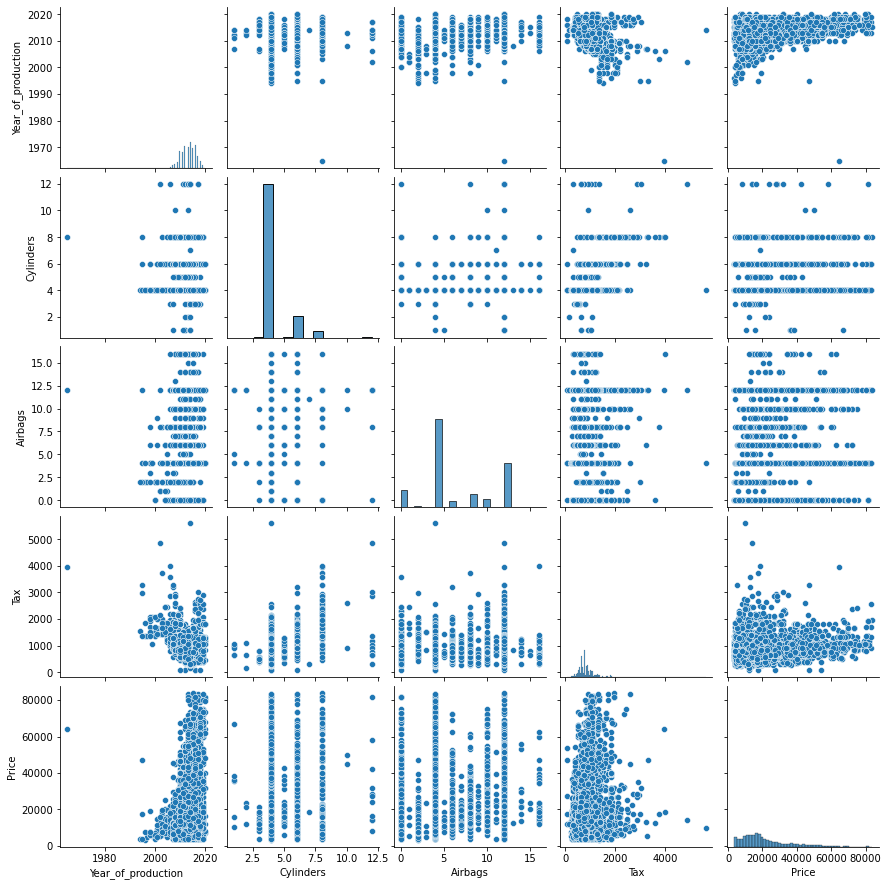

In [25]:
ax = sns.pairplot(df, palette= 'inferno')

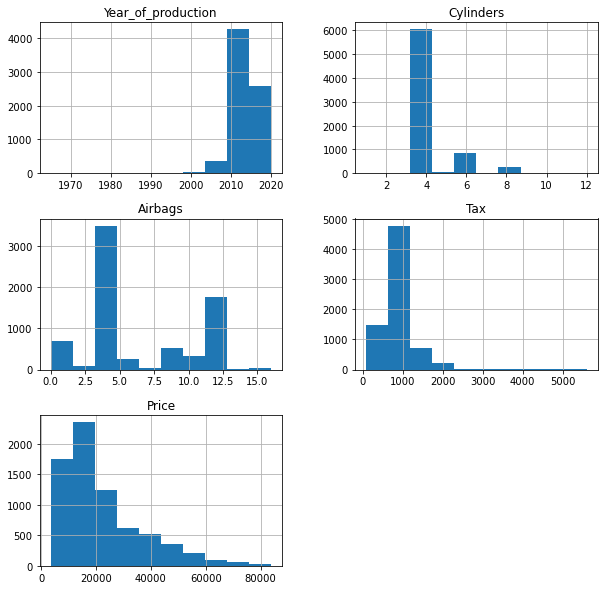

In [674]:
df.hist(figsize=(10, 10));

In [3]:
# Функции для обработки колонок с буквами, а также для их разделения
def volume(s):
    if len(s) <= 3:
        a = s
    else:
        a = s[:3]
    return a;

def turbo(df):
    b = []
    for i in range(len(df)):
        if df['Engine_volume'][i][4:] == 'Turbo':
            b.append(1)    
        else:
            b.append(0)
    return pd.Series(b);

In [4]:
# Делаю новую колонку Турбо, чтобы выделять машины с турбированным двигателем
# а также разделяю пробег от километров и делаю из этого целые числа
df['Turbo'] = 0
df['Turbo'] = turbo(df)
df['Engine_volume'] = [volume(i) for i in df['Engine_volume']]
df['Engine_volume'] = df['Engine_volume'].astype(float)
df.Mileage = [int(''.join(filter(str.isdigit, i ))) for i in df.Mileage]

In [5]:
# Ниже буду выбрасывать выбросы, которые нашел по графикам
ind = df[df['Engine_volume'] == 0].index
## Объем двигателя Тойота Аква составляет 1.5 л. Мощность двигателей Toyota Aqua от 74 до 91 л.
#
# это некорректные данные, поэтому удаляем их
df = df.drop(index=ind)
##Автомобиль комплектовался моторами объёмом: 1.6, 2.0, 2.4 л.
inde = df[df['Engine_volume'] == 20].index
df = df.drop(index=inde)
# вприципе щас нет таких автомобилей с 20 и 0 литровыми движками, тем более Соната 2014 года
# Она выпускалась, только с 1,6 и 2,4л, ну не как не 20
# машины с 0 л двигателем это скорее просто некорретные данные, тк как она тогда ездит?
#ладно бы 0,6 или 0,8, но 0 это очеьн странно, поэтому дропаю

In [ ]:
# еще надо посмотреть минимальную цену
# и посмотреть дубликаты
# убрать выбросы с годом и глянуть еще на другие

In [6]:
# есть дубликаты, поэтому убираем дубликаты
#display(df[df.duplicated()].head(60))
df_duplicates = df.drop('Price', axis = 1)
dupl_rows = df_duplicates[df_duplicates.duplicated()].index
df = df.drop(index=dupl_rows)
df = df.drop_duplicates(keep = 'first')

In [13]:
df = df.drop(columns=['Model'])

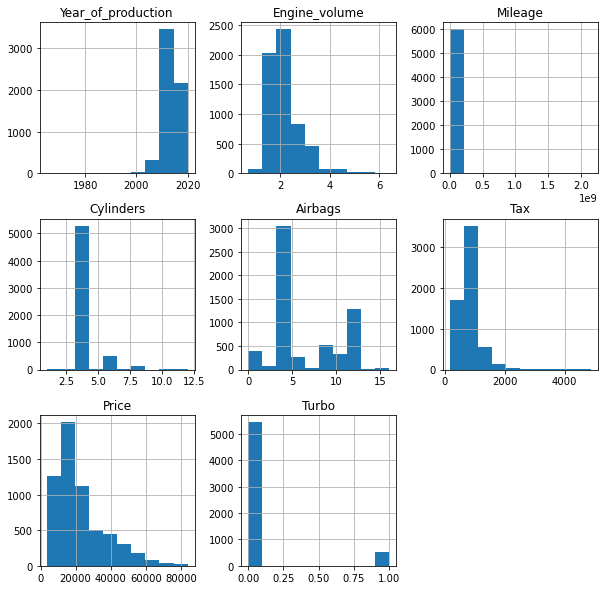

In [670]:
df.hist(figsize=(10, 10));

In [7]:
df.Mileage.nlargest(15)
# если загуглить, то можно увидеть, что можно прочитать
# Книги рекордов Гиннеса цифра – 3,2 миллиона миль (5 149 900 км) – датируется маем 2013 года.
# логично, что все пробеги ниже этого очень большого числа подходят под условия
# убираем это большьшое число(удаляем по индексу)
df = df.drop(index = 3169)

In [742]:
df.Tax.nsmallest(10)
# минимальный налог это bmw i3 - там все нормально, за такую машину с 0.7л двигателем и примерно 35 л.с
# такой налог нормальный

5881    173
896     247
2862    247
5253    247
99      259
1764    259
1820    259
222     271
644     271
1281    271
Name: Tax, dtype: int64

In [743]:
df.Tax.nlargest(10)
# За мерседес с 6л двигателем и где то 340+ л.с. налог идет нормальный, поэтому это не выброс

847     4860
5674    3989
787     3965
620     3743
1886    3571
7146    3292
5486    3268
3302    3208
4705    3015
3145    2971
Name: Tax, dtype: int64

,Year_of_production,Engine_volume,Mileage,Cylinders,Airbags,Tax,Price,Turbo
Year_of_production,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Engine_volume,-0.062198,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Mileage,-0.207822,0.066018,NaN,NaN,NaN,NaN,NaN,NaN
Cylinders,-0.073365,0.711521,0.042856,NaN,NaN,NaN,NaN,NaN
Airbags,0.069357,0.236599,-0.077654,0.241629,NaN,NaN,NaN,NaN
Tax,-0.185914,0.714090,0.012382,0.528068,0.111614,NaN,NaN,NaN
Price,0.414475,0.169238,-0.255588,0.085066,-0.092562,0.151192,NaN,NaN
Turbo,-0.075044,-0.063485,-0.024878,0.054531,0.180725,0.003567,0.043578,NaN


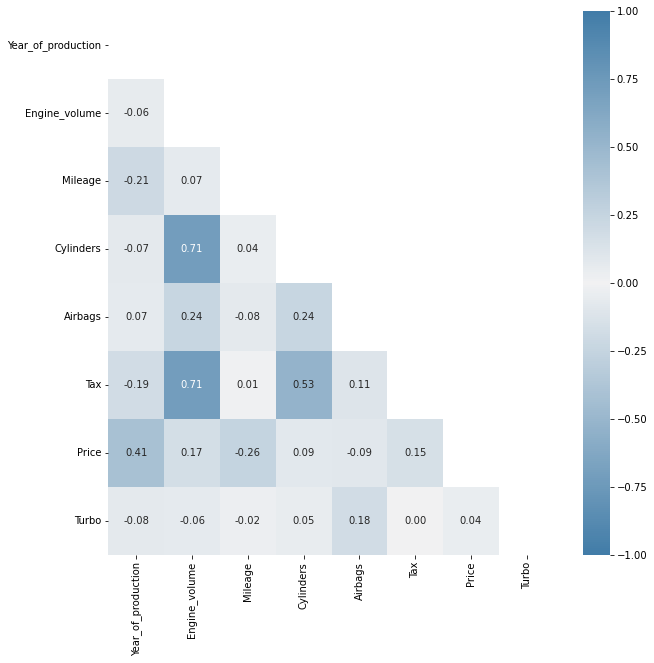

In [527]:
plt.figure(figsize=(10,10))

corr_matrix = df.corr()
mask = np.tril(corr_matrix, k = -1).astype(bool)
display(corr_matrix.where(mask))

mymap = sns.diverging_palette(240, 240, as_cmap = True)

sns.heatmap(corr_matrix.where(mask), vmin = -1, vmax = 1,
            annot=True, fmt='.2f', center=0, cmap=mymap);

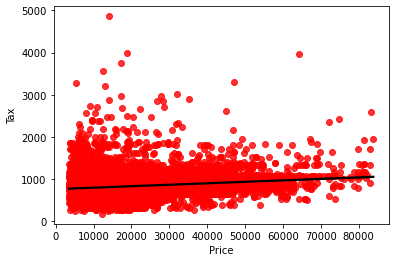

In [528]:
ax = sns.regplot(x = 'Price' , y = 'Tax', data = df, fit_reg= True, scatter_kws= {'color':'red'}, line_kws={'color':'black'})

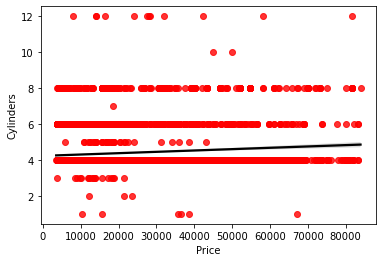

In [60]:
ax = sns.regplot(x = 'Price' , y = 'Cylinders', data = df, fit_reg= True, scatter_kws= {'color':'red'}, line_kws={'color':'black'})

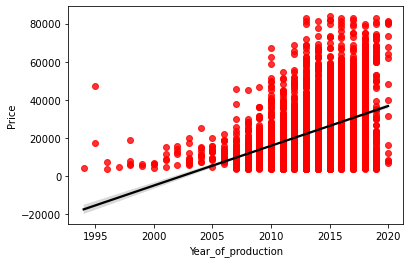

In [702]:
ax = sns.regplot(x = 'Year_of_production' , y = 'Price', data = df, fit_reg= True, scatter_kws= {'color':'red'}, line_kws={'color':'black'})

In [703]:
df['Year_of_production'].nsmallest(5)

3311    1994
3145    1995
7146    1995
840     1996
5419    1996
Name: Year_of_production, dtype: int64

In [8]:
display(df[df['Year_of_production'] < 1999].Price)
# Машина за почти за 50000 1995 года будет довольно сильно колебать мое обучение, поэтому считаю выбросом 
# и выбрасываю ее
df = df.drop(index=7146)

469      7840
787     64290
840      3500
1046     4704
2557     6272
3047     7840
3145    17249
3311     4077
3409    19130
5156     5959
5379     4077
5419     7527
6606     7840
7146    47042
Name: Price, dtype: int64

In [9]:
# пока тоже думаю насчет машины 1965 года, которая очень сильно идет отдельно
# чтобы не мотало модель, я уберу машину 1995 года, тк это очеьн сильно сказывается на обучениим
df = df[df['Year_of_production'] > 1965]
# все же убираю, поскольку считаю выбросом

23673.452191641183
17557.522881355933


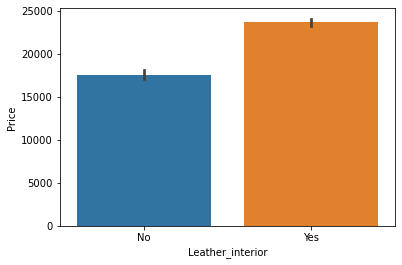

In [606]:
sns.barplot(data=df, x='Leather_interior', y ='Price')
# можно увидеть, что цена автомобилей выше, где есть кожаный салон, ну это и лочгино
# поэтому можно будет перекодировать 0 - НЕТ, а 1-ДА
print(df[df['Leather_interior']=='Yes'].Price.mean())
print(df[df['Leather_interior']=='No'].Price.mean())
#df['Leather_interior'] = np.where(df['Leather_interior']=='Yes',1,0)

26973.74045432576
22279.28203708829
15465.594569288389
13204.461377870564


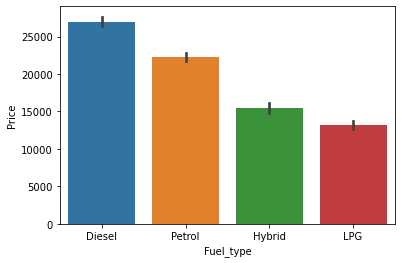

In [107]:
sns.barplot(data=df, x='Fuel_type', y ='Price')
# по этому графику можно увидеть, что большую цену имеют авто с дизелем и бензином, остальные меньше
# поэтому я бы сделал замену в иерхическом порядке
# можно посмотреть средние по ценам в зависимости от вида топлива
print(df[df['Fuel_type']=='Diesel'].Price.mean())
print(df[df['Fuel_type']=='Petrol'].Price.mean())
print(df[df['Fuel_type']=='Hybrid'].Price.mean())
print(df[df['Fuel_type']=='LPG'].Price.mean())
#######
#df['Fuel_type'] = df['Fuel_type'].replace({'Diesel':3,'Petrol':2,'Hybrid':1,'LPG':0})

25226.816720257233
21901.473639743155
17530.244047619046
14529.92857142857


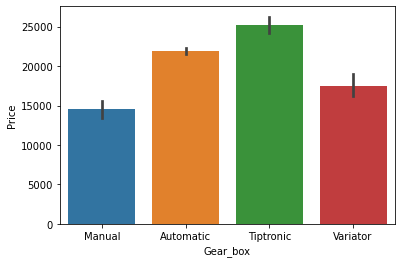

In [109]:
# Аналогичная ситуация как с видом топлива, можно сделать в иерархическом порядке
sns.barplot(data=df, x='Gear_box', y ='Price')
########
print(df[df['Gear_box']=='Tiptronic'].Price.mean())
print(df[df['Gear_box']=='Automatic'].Price.mean())
print(df[df['Gear_box']=='Variator'].Price.mean())
print(df[df['Gear_box']=='Manual'].Price.mean())
##########
#df['Gear_box'] = df['Gear_box'].replace({'Tiptronic':3,'Automatic':2,'Variator':1,'Manual':0})

20071.0
18189.0
17562.0


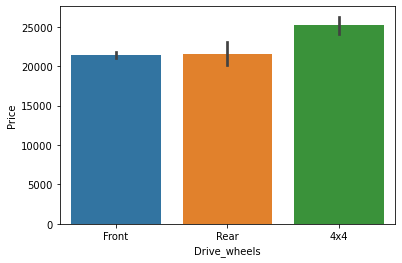

In [111]:
# Аналогичная ситуация, можно сделать в иерархическом порядке
sns.barplot(data=df, x='Drive_wheels', y ='Price')
#####
print(df[df['Drive_wheels']=='4x4'].Price.mean())
print(df[df['Drive_wheels']=='Rear'].Price.mean())
print(df[df['Drive_wheels']=='Front'].Price.mean())
#df['Drive_wheels'] = df['Drive_wheels'].replace({'4x4':2,'Rear':1,'Front':0})

22573.69221737672
22216.25
17359.76767676768


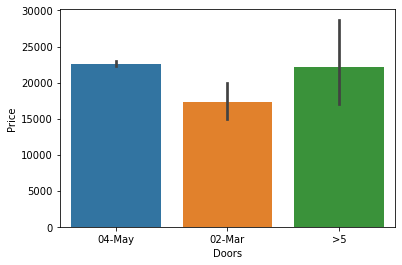

In [607]:
sns.barplot(data=df, x='Doors', y ='Price')
### Да, тут видно, что более или 5 дверей в среднем стоят больше
# но большой ус говорит о том, что есть парочку нестандартных кейсов, как и показано ниже
# есть парочку машин, которые отличаются от нормальной цены в этой категории
#поэтому я бы все равно сделал, что 4 двери шло бы на первом месте, поскольку они более менее стабильно ведет себя
print(df[df['Doors']=='04-May'].Price.mean())
print(df[df['Doors']=='>5'].Price.mean())
print(df[df['Doors']=='02-Mar'].Price.mean())
#df['Doors'] = df['Doors'].replace({'04-May':2,'>5':1,'02-Mar':0})
##### тут можно посмотреть самые дорогие и увидеть сильные качели в цене по сравнению с 4 дверьми
#print(df[df['Doors']=='>5'].Price.nlargest(5))
#print(df[df['Doors']=='04-May'].Price.nlargest(5))

4075    83251
4226    57526
2230    30734
4346    30734
2850    21326
Name: Price, dtype: int64
4964    68994
597     42000
2186    35124
1359    25716
5245    21940
Name: Price, dtype: int64


Type
Goods wagon    10804.000000
Hatchback      15707.594987
Sedan          17849.767367
Microbus       18032.450980
Coupe          22770.863354
Minivan        26665.763052
Pickup         26757.333333
Jeep           29205.044700
Universal      31037.315476
Cabriolet      32846.625000
Name: Price, dtype: float64

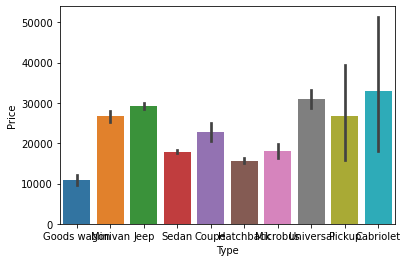

In [371]:
# тут тоже есть весьма не нормальные цены по некоторым категориям, тк видим большие усы
sns.barplot(data=df, x='Type',y= 'Price')
# посмотрим на кабриолет и пикапы
print(df[df.Type=='Cabriolet'].Price.nlargest(5))
print(df[df.Type=='Pickup'].Price.nlargest(5))
# возможно сделаю через OneHot и посмотрим
display(df.groupby("Type")["Price"].mean().sort_values())

Color
Orange           12067.385542
Purple           13211.000000
Pink             14504.750000
Golden           16842.351351
Sky blue         16882.807692
Green            17902.673077
Beige            18844.000000
Silver           19366.269799
Red              19366.445455
Carnelian red    19528.500000
Blue             22525.555804
White            22567.013016
Black            23799.920131
Grey             24197.194389
Brown            24378.426230
Yellow           26426.187500
Name: Price, dtype: float64

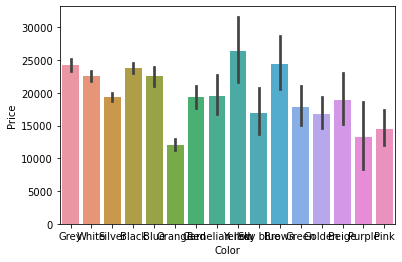

In [370]:
# с цветами однозначного ответа нет,поэтому я бы просто сделал через OneHot тк особо нет иерархии тут
sns.barplot(data=df, x='Color',y= 'Price')
display(df.groupby("Color")["Price"].mean().sort_values())

Cylinders
3.0     13356.111111
7.0     18503.000000
2.0     19026.000000
5.0     19149.666667
6.0     20522.175708
4.0     21683.670310
12.0    31178.916667
1.0     33928.833333
8.0     34535.810606
10.0    47432.000000
Name: Price, dtype: float64

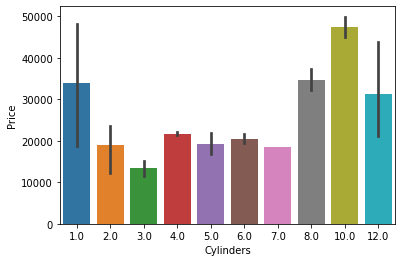

In [382]:
sns.barplot(data=df, x='Cylinders',y= 'Price')
Cyl = df.groupby("Cylinders")["Price"].mean().sort_values()
display(Cyl)
# здесь немного неоднозначно, но можно выделить тенденцию, что при увеличении цилиндров - цена растет

<AxesSubplot:xlabel='Cylinders', ylabel='count'>

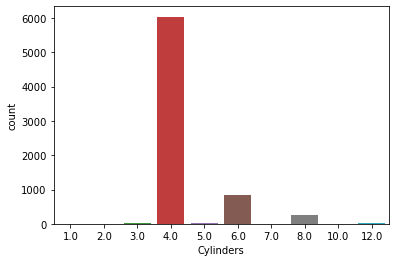

In [388]:
# видим, что большинство людей выбирают 4 цилиндра
sns.countplot(df.Cylinders)

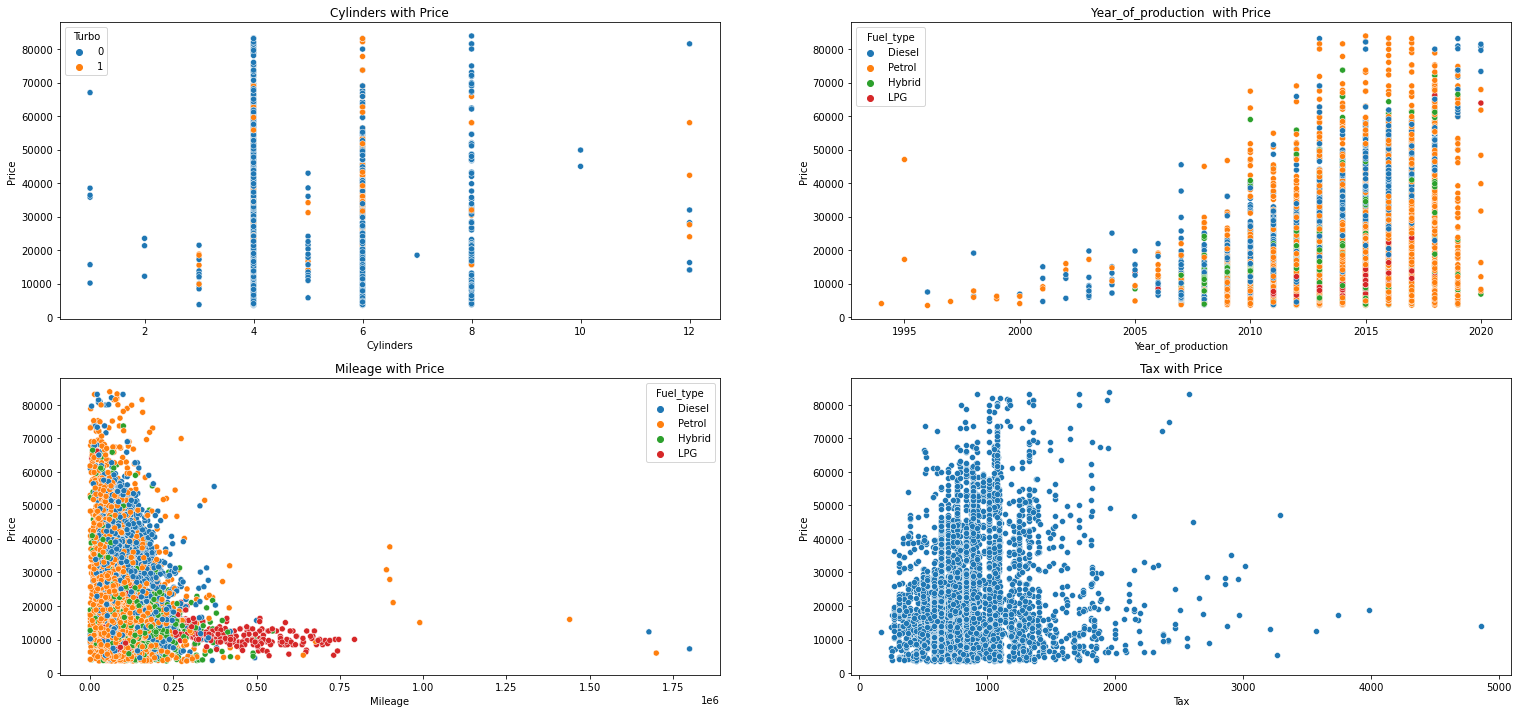

In [700]:
fig = plt.figure(figsize=(26, 12))

ax1 = fig.add_subplot(221)
sns.scatterplot(data=df,x="Cylinders",y="Price", hue="Turbo",markers=True)

ax2 = fig.add_subplot(222)
sns.scatterplot(data=df,x="Year_of_production",y="Price",hue="Fuel_type",markers=True)

ax3 = fig.add_subplot(223)
sns.scatterplot(data=df,x="Mileage",y="Price",hue="Fuel_type",markers=True)

ax4 = fig.add_subplot(224)
sns.scatterplot(data=df,x="Tax",y="Price",markers=True)

ax1.title.set_text('Cylinders with Price')
ax2.title.set_text('Year_of_production  with Price')
ax3.title.set_text('Mileage with Price')
ax4.title.set_text('Tax with Price')
plt.show()

In [696]:
display(df.groupby("Brand")["Price"].mean().sort_values())
display(df.Brand.value_counts())

Brand
DAEWOO            7142.434783
GMC               8749.600000
OPEL              8995.836735
DAIHATSU          9095.000000
CHRYSLER          9430.857143
SCION            10976.000000
DODGE            11831.590909
BUICK            12027.166667
FIAT             12452.750000
RENAULT          13772.111111
SUBARU           15391.982456
NISSAN           15588.783784
MERCURY          15681.000000
CADILLAC         16098.666667
VOLKSWAGEN       16127.414013
KIA              16817.900000
INFINITI         17118.000000
CHEVROLET        17412.390681
CITROEN          18189.000000
ACURA            18450.666667
VAZ              18503.000000
MINI             18807.000000
FORD             19491.235294
TOYOTA           20213.273101
VOLVO            21326.000000
LINCOLN          21639.000000
MAZDA            23117.571429
MITSUBISHI       23157.151515
AUDI             23809.224490
HYUNDAI          24611.526575
BMW              24949.000000
HONDA            26221.818182
MASERATI         26813.500000
MERC

HYUNDAI          2032
TOYOTA            974
CHEVROLET         558
SSANGYONG         324
FORD              323
MERCEDES-BENZ     247
HONDA             242
KIA               210
BMW               186
LEXUS             162
VOLKSWAGEN        157
NISSAN            111
SUBARU             57
AUDI               49
OPEL               49
JEEP               47
DAEWOO             46
MITSUBISHI         33
MAZDA              28
FIAT               24
DODGE              22
JAGUAR             14
PORSCHE            11
MINI                9
RENAULT             9
LAND ROVER          8
CHRYSLER            7
BUICK               6
SUZUKI              6
CADILLAC            6
INFINITI            6
GMC                 5
ACURA               3
CITROEN             2
MASERATI            2
MERCURY             1
FERRARI             1
VOLVO               1
VAZ                 1
SKODA               1
SCION               1
LINCOLN             1
DAIHATSU            1
Name: Brand, dtype: int64

In [10]:
df[df.Mileage == 0]
# машина с 2011 года стоит без минимального пробега хотя бы, это очень странно, даже если салонная, ее бы уже использовали
# считаю, что можно будет выбросить, но после построения моделей
idn = df[df.Mileage == 0].index
df = df.drop(index=idn)

# Column Transformer

In [15]:
columns = ['Brand','Type','Color','Fuel_type','Gear_box','Drive_wheels','Year_of_production','Mileage','Tax','Leather_interior','Doors','Engine_volume','Cylinders','Airbags','Turbo']
cat_features = ['Brand','Type','Color']
num_features = ['Year_of_production','Mileage','Tax']
y = np.array(df.Price)
X = df.drop(columns=['Price'])

In [16]:
fuel_type_map = [{
    'col':'Fuel_type', 
    'mapping':{'Diesel':3,'Petrol':2,'Hybrid':1,'LPG':0}
    }]
gear_box_map = [{
    'col':'Gear_box',
    'mapping':{'Tiptronic':3,'Automatic':2,'Variator':1,'Manual':0}
    }]
drive_wheels_map = [{
    'col':'Drive_wheels',
    'mapping':{'4x4':2,'Rear':1,'Front':0}
    }]
doors_map = [{
    'col':'Doors',
    'mapping':{'04-May':2,'>5':1,'02-Mar':0}
    }]
leather_interior_map = [{
    'col':'Leather_interior',
    'mapping':{'Yes':1,'No':0}
    }]

fuel_transformer = Pipeline(steps=[
    ('ce',ce.OrdinalEncoder(mapping = fuel_type_map))])

gear_box_transformer = Pipeline(steps=[
    ('ce',ce.OrdinalEncoder(mapping = gear_box_map))])

drive_wheels_transformer = Pipeline(steps=[
    ('ce',ce.OrdinalEncoder(mapping = drive_wheels_map))])

doors_transformer = Pipeline(steps=[
    ('ce',ce.OrdinalEncoder(mapping = doors_map))])

leather_transformer = Pipeline(steps=[
    ('ce',ce.OrdinalEncoder(mapping = leather_interior_map))])

   
# для деревьев можно не стандартизировать данные в фичах 
CT = ColumnTransformer(transformers=[('cat',OrdinalEncoder(),cat_features),
                                     ('fuel_type', fuel_transformer, ['Fuel_type']),
                                     ('gear_box', gear_box_transformer, ['Gear_box']),
                                     ('drive_wheels', drive_wheels_transformer, ['Drive_wheels']),
                                     ('num','passthrough',num_features), #StandardScaler()
                                     ('leather',leather_transformer,['Leather_interior']),
                                     ('doors', doors_transformer, ['Doors'])],
                                      remainder = 'passthrough')

display(CT)

X_CT = CT.fit_transform(X)#.toarray()
X_CT = pd.DataFrame(X_CT,columns=columns)
display(X_CT)

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat', OrdinalEncoder(),
                                 ['Brand', 'Type', 'Color']),
                                ('fuel_type',
                                 Pipeline(steps=[('ce',
                                                  OrdinalEncoder(mapping=[{'col': 'Fuel_type',
                                                                           'mapping': {'Diesel': 3,
                                                                                       'Hybrid': 1,
                                                                                       'LPG': 0,
                                                                                       'Petrol': 2}}]))]),
                                 ['Fuel_type']),
                                ('gear_box',
                                 Pipeline(steps=[('ce',
                                                  OrdinalEncoder(mapping=[{'col': 'Gear_box',
                                                                           'mapping': {'Auto...
                                                                                       'Rear': 1}}]))]),
                                 ['Drive_wheels']),
                                ('num', 'passthrough',
                                 ['Year_of_production', 'Mileage', 'Tax']),
                                ('leather',
                                 Pipeline(steps=[('ce',
                                                  OrdinalEncoder(mapping=[{'col': 'Leather_interior',
                                                                           'mapping': {'No': 0,
                                                                                       'Yes': 1}}]))]),
                                 ['Leather_interior']),
                                ('doors',
                                 Pipeline(steps=[('ce',
                                                  OrdinalEncoder(mapping=[{'col': 'Doors',
                                                                           'mapping': {'02-Mar': 0,
                                                                                       '04-May': 2,
                                                                                       '>5': 1}}]))]),
                                 ['Doors'])])

,Brand,Type,Color,Fuel_type,Gear_box,Drive_wheels,Year_of_production,Mileage,Tax,Leather_interior,Doors,Engine_volume,Cylinders,Airbags,Turbo
0,31.0,2.0,7.0,3.0,0.0,0.0,2003.0,152000.0,1438.0,0.0,2.0,1.7,4.0,2.0,0.0
1,26.0,6.0,14.0,3.0,0.0,1.0,2008.0,198700.0,1195.0,0.0,0.0,2.2,4.0,6.0,1.0
2,39.0,4.0,7.0,2.0,2.0,0.0,2018.0,37214.0,1079.0,0.0,2.0,2.0,4.0,10.0,0.0
3,16.0,8.0,12.0,2.0,2.0,0.0,2012.0,137235.0,919.0,1.0,2.0,3.0,4.0,4.0,0.0
4,26.0,4.0,7.0,3.0,2.0,2.0,2015.0,79080.0,1273.0,1.0,2.0,3.5,6.0,12.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5892,13.0,8.0,12.0,1.0,3.0,0.0,2018.0,39000.0,505.0,1.0,2.0,2.0,4.0,12.0,0.0
5893,26.0,8.0,1.0,2.0,3.0,2.0,2013.0,156800.0,1055.0,1.0,2.0,3.5,4.0,12.0,0.0
5894,20.0,4.0,1.0,2.0,2.0,2.0,2019.0,18206.0,1275.0,1.0,2.0,2.4,4.0,12.0,0.0
5895,16.0,8.0,1.0,2.0,3.0,0.0,2014.0,148800.0,749.0,0.0,2.0,2.4,4.0,6.0,0.0


In [749]:
# после создания трансформера в этой файле пошел делать все отдельно в другие и потом сюда перенес результаты
# которые сделал в файлах Model,Features

## Все следующие преобразования есть в файлах Models,Feature

### Это будет итоговая модель с итоговым траин фреймом перед 3 блоком

In [17]:
# возьму преобразование Бокса-Кокса для пробег и налога
# преобраазуем переменные пробег и налог
power = PowerTransformer(method='box-cox') 
minmax = MinMaxScaler()

mile = power.fit_transform(minmax.fit_transform(pd.DataFrame(X_CT.Mileage)) + 1)
tax = power.fit_transform(minmax.fit_transform(pd.DataFrame(X_CT.Tax)) + 1)


X_CT.Mileage = mile
X_CT.Tax = tax
#преобразовываю данные и записываю в колонки моего Х после трансформера
# скорее всего это преобразование буду делать до трансформера,то есть сразу преобразовывать фрейм по этим колонкам
# тк трудно будет сделать преобразования после pipeline

In [18]:
#('Doors','Cylinders','Leather_interior') убираю из-за неинформативности признаков
X_CT = X_CT.drop(columns=['Doors','Cylinders','Leather_interior'])

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_CT, y, test_size= 0.25)

In [22]:
estimator = RandomForestRegressor(n_estimators=3500)
estimator.fit(X_train,y_train)
y_pred = estimator.predict(X_test)
print('R2',r2_score(y_test,y_pred))
print('MSE', mean_squared_error(y_test,y_pred))
print('MAPE',mean_absolute_percentage_error(y_test,y_pred))

R2 0.700678224176357
MSE 61557187.18235468
MAPE 0.33814648053808327
